In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using BenchmarkTools
using Flux
using ReverseDiff
using Random
using Plots
using LinearAlgebra

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future 

In [2]:
Random.seed!(1234);

In [3]:
# Lorenz system equations to be used to generate dataset
Base.@kwdef mutable struct Lorenz
    dt::Float64
    σ::Float64
    ρ::Float64
    β::Float64
    x::Float64
    y::Float64
    z::Float64
end

function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x);         l.x += l.dt * dx
    dy = l.x * (l.ρ - l.z) - l.y;   l.y += l.dt * dy
    dz = l.x * l.y - l.β * l.z;     l.z += l.dt * dz
end
;

In [4]:
#Dataset
ordered_dataset = []
ordered_parameters = []

for σ = 11:15
    for ρ = 23:27
        for β_nom = 6:9
            attractor = Lorenz(0.02, σ, ρ, β_nom/3.0, 1, 1, 1)
            noise_free_data = [[1.0, 1.0, 1.0]]
            for i=1:99
                step!(attractor)
                push!(noise_free_data, [attractor.x, attractor.y, attractor.z])
            end
            push!(ordered_dataset, noise_free_data)
            push!(ordered_parameters, [σ, ρ, β_nom/3.0])
        end
    end
end

new_order = collect(1:100)
shuffle!(new_order)

dataset = [] #noisy dataset
noise_free_dataset = [] #noise free dataset
lorenz_parameters = []

for i in new_order
    data = []
    push!(noise_free_dataset, ordered_dataset[i])
    push!(lorenz_parameters, ordered_parameters[i])
    for nfd in ordered_dataset[i]
        push!(data,nfd+randn(3))
    end
    push!(dataset, data)
end

trainset = dataset[1:60]
validset = dataset[61:80]
testset = dataset[81:end]

noise_free_trainset = noise_free_dataset[1:60]
noise_free_validset = noise_free_dataset[61:80]
noise_free_testset = noise_free_dataset[81:end]
;

In [5]:
#Neural Network model
mutable struct NN
    InputLayer
    Lstm
    OutputLater
    g
    params

    function NN(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)
        InputLayer = Dense(W1, b1, relu)
        Lstm = LSTM(W2_1,W2_2,b2,s2_1,s2_2)
        OutputLayer = Dense(W3, b3)
        g = Chain(InputLayer, Lstm, OutputLayer);
        new(InputLayer, Lstm, OutputLayer, g, (W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3))
    end
end

In [6]:
#State Space Model
@model function ssm(n, As, Q::ConstVariable, B::ConstVariable, R::ConstVariable)
   
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior_mean = zeros(3)
    x_prior_cov  = Matrix(Diagonal(ones(3)))
    
    x[1] ~ MvNormalMeanCovariance(x_prior_mean, x_prior_cov)
    y[1] ~ MvNormalMeanCovariance(B * x[1], R) where { q = q(mean)q(out)q(cov) }
    
    for i in 2:n
        x[i] ~ MvNormalMeanCovariance(As[i - 1] * x[i - 1], Q) where { q = q(mean, out)q(cov) }
        y[i] ~ MvNormalMeanCovariance(B * x[i], R) where { q = q(mean)q(out)q(cov) }
    end
    
    return x, y
end

ssm (generic function with 1 method)

In [7]:
Q = Matrix(Diagonal(ones(3)))
B = Matrix(Diagonal(ones(3)))
R = Matrix(Diagonal(ones(3)))
;

In [8]:
function inference(data, W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)
    n = length(data)
    
    neural = NN(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)
    Flux.reset!(neural.Lstm)
    
    As  = map((d) -> Diagonal(neural.g(d)), data[1:end-1])
    
    model, (x, y) = ssm(n, As, Q, B, R)
    
    x_buffer = Vector{Marginal}(undef, n)
    fe_value = nothing
    
    x_subscription = subscribe!(collectLatest(getmarginals(x)), (xs) -> copyto!(x_buffer, xs))
    f_subscription = subscribe!(score(BetheFreeEnergy(), model, AsapScheduler()), (fe) -> fe_value = fe)
    
    for i in 1:n
        update!(y[i], data[i])
    end
    
    unsubscribe!(x_subscription)
    unsubscribe!(f_subscription)
    Flux.reset!(neural.Lstm)
    
    return x_buffer, fe_value
end

inference (generic function with 1 method)

In [9]:
# Initial model parameters
W1, b1 = randn(5,3)./100, randn(5)./100
W2_1, W2_2, b2, s2_1, s2_2 = randn(5 * 4, 5)./100, randn(5 * 4, 5)./100, randn(5*4)./100, zeros(5), zeros(5)
W3, b3 = randn(3,5)./100, randn(3)./100
;

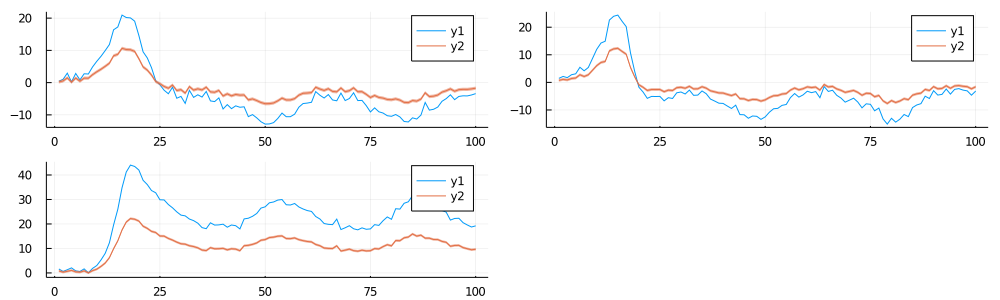

In [10]:
# Performance on an instance from the testset before training
index = 1
x_est, f_est = inference(testset[index], W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)

rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

p1 = plot(rx)
p1 = plot!(rx_est_m, ribbon=rx_est_var)

p2 = plot(ry)
p2 = plot!(ry_est_m, ribbon=ry_est_var)

p3 = plot(rz)
p3 = plot!(rz_est_m, ribbon=rz_est_var)

plot(p1, p2, p3, size = (1000, 300))

In [11]:
# free energy objective to be optimized during training
function fe_tot_est(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)
    fe_ = 0
    for train_instance in trainset
        fe_est(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3) = begin xm, fe = inference(train_instance, W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3); fe end
        fe_ += fe_est(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)
    end
    return fe_
end

fe_tot_est (generic function with 1 method)

In [12]:
@time fe_tot_est(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)
@time fe_tot_est(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)
@btime fe_tot_est(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)

  2.182374 seconds (16.14 M allocations: 1.035 GiB, 13.34% gc time)
  1.893943 seconds (15.24 M allocations: 1012.902 MiB, 13.52% gc time)
  1.634 s (15239040 allocations: 1012.90 MiB)


1.0977117148316503e6

In [13]:
# To track the performance on validation set
function fe_valid_est(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)
    fe_ = 0
    for valid_instance in validset
        fe_est(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3) = begin xm, fe = inference(valid_instance, W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3); fe end
        fe_ += fe_est(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)
    end
    return fe_
end

fe_valid_est (generic function with 1 method)

In [14]:
# training
opt = Flux.Optimise.RMSProp(0.001, 0.9)
params = (W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)

for epoch=1:100
    println(epoch)
    grads = ReverseDiff.gradient(fe_tot_est, params);
    for i=1:length(params)
        Flux.Optimise.update!(opt,params[i],grads[i])
    end
    println(fe_valid_est(W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3))
end

1
377509.60415867704
2
376592.023477536
3
375778.39315697236
4
374991.7776803644
5
374189.889142158
6
373346.44077003974
7
372441.1164616938
8
371455.775147408
9
370373.19459072006
10
369176.57797098305
11
367850.7409100224
12
366383.06570015737
13
364765.1368896445
14
362994.01197058125
15
361073.52858142246
16
359013.48829484876
17
356828.18732685875
18
354532.90395991935
19
352140.30332499347
20
349656.6835238017
21
347075.3233142234
22
344365.9843096088
23
341478.6083275829
24
338356.8566484656
25
334961.4641987339
26
331273.50326157437
27
327282.26506445126
28
322980.77704788744
29
318367.5584363668
30
313452.95399179833
31
308262.1404125645
32
302836.76233653637
33
297233.50528285763
34
291519.253230197
35
285763.7947050766
36
280032.0111898574
37
274377.69472264504
38
268840.3137698496
39
263444.7819128702
40
258203.36968989027
41
253118.60439976407
42
248186.2636445544
43
243397.9377945655
44
238742.98039688103
45
234209.87004921152
46
229787.09317401279
47
225463.67592038828
4

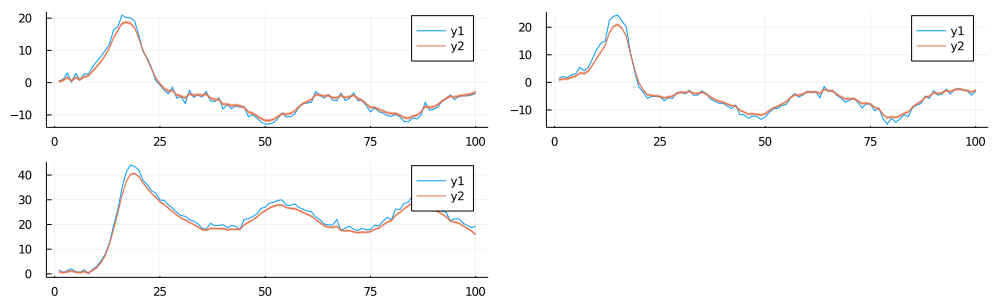

In [15]:
# test after training
index = 1
x_est, f_est = inference(testset[index], W1,b1,W2_1,W2_2,b2,s2_1,s2_2,W3,b3)

rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

p1 = plot(rx)
p1 = plot!(rx_est_m, ribbon=rx_est_var)

p2 = plot(ry)
p2 = plot!(ry_est_m, ribbon=ry_est_var)

p3 = plot(rz)
p3 = plot!(rz_est_m, ribbon=rz_est_var)

plot(p1, p2, p3, size = (1000, 300))